# CSCE 623 SP 2019 Assignment 4
## Crow, David
## 20190514

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import scale 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# begin student imports ---
from timeit import default_timer as timer
from itertools import combinations
# --- end student imports

pd.set_option('display.notebook_repr_html', False)

%matplotlib inline
plt.style.use('seaborn-white')

import warnings
warnings.filterwarnings('ignore')
#warnings.filterwarnings(action='once')

# STEP 0:  Load Data

In [2]:
df = pd.read_csv('ISLR_Hitters.csv', index_col=0).dropna()
df.index.name = 'Player'
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, Alan Ashby to Willie Wilson
Data columns (total 20 columns):
AtBat        263 non-null int64
Hits         263 non-null int64
HmRun        263 non-null int64
Runs         263 non-null int64
RBI          263 non-null int64
Walks        263 non-null int64
Years        263 non-null int64
CAtBat       263 non-null int64
CHits        263 non-null int64
CHmRun       263 non-null int64
CRuns        263 non-null int64
CRBI         263 non-null int64
CWalks       263 non-null int64
League       263 non-null object
Division     263 non-null object
PutOuts      263 non-null int64
Assists      263 non-null int64
Errors       263 non-null int64
Salary       263 non-null float64
NewLeague    263 non-null object
dtypes: float64(1), int64(16), object(3)
memory usage: 43.1+ KB


In [3]:
df.head()

                  AtBat  Hits  HmRun  Runs  RBI  Walks  Years  CAtBat  CHits  \
Player                                                                         
Alan Ashby          315    81      7    24   38     39     14    3449    835   
Alvin Davis         479   130     18    66   72     76      3    1624    457   
Andre Dawson        496   141     20    65   78     37     11    5628   1575   
Andres Galarraga    321    87     10    39   42     30      2     396    101   
Alfredo Griffin     594   169      4    74   51     35     11    4408   1133   

                  CHmRun  CRuns  CRBI  CWalks League Division  PutOuts  \
Player                                                                   
Alan Ashby            69    321   414     375      N        W      632   
Alvin Davis           63    224   266     263      A        W      880   
Andre Dawson         225    828   838     354      N        E      200   
Andres Galarraga      12     48    46      33      N        E      80

In [4]:
dummies = pd.get_dummies(df[['League', 'Division', 'NewLeague']])
dummies.info()
print(dummies.head())

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, Alan Ashby to Willie Wilson
Data columns (total 6 columns):
League_A       263 non-null uint8
League_N       263 non-null uint8
Division_E     263 non-null uint8
Division_W     263 non-null uint8
NewLeague_A    263 non-null uint8
NewLeague_N    263 non-null uint8
dtypes: uint8(6)
memory usage: 3.6+ KB
                  League_A  League_N  Division_E  Division_W  NewLeague_A  \
Player                                                                      
Alan Ashby               0         1           0           1            0   
Alvin Davis              1         0           0           1            1   
Andre Dawson             0         1           1           0            0   
Andres Galarraga         0         1           1           0            0   
Alfredo Griffin          1         0           0           1            1   

                  NewLeague_N  
Player                         
Alan Ashby                  1  
Alv

In [5]:
y = df.Salary

# Drop the column with the independent variable (Salary), and columns for which we created dummy variables
X_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')
# Define the feature set X.
X = pd.concat([X_, dummies[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, Alan Ashby to Willie Wilson
Data columns (total 19 columns):
AtBat          263 non-null float64
Hits           263 non-null float64
HmRun          263 non-null float64
Runs           263 non-null float64
RBI            263 non-null float64
Walks          263 non-null float64
Years          263 non-null float64
CAtBat         263 non-null float64
CHits          263 non-null float64
CHmRun         263 non-null float64
CRuns          263 non-null float64
CRBI           263 non-null float64
CWalks         263 non-null float64
PutOuts        263 non-null float64
Assists        263 non-null float64
Errors         263 non-null float64
League_N       263 non-null uint8
Division_W     263 non-null uint8
NewLeague_N    263 non-null uint8
dtypes: float64(16), uint8(3)
memory usage: 35.7+ KB


In [6]:
X.head(5)

                  AtBat   Hits  HmRun  Runs   RBI  Walks  Years  CAtBat  \
Player                                                                    
Alan Ashby        315.0   81.0    7.0  24.0  38.0   39.0   14.0  3449.0   
Alvin Davis       479.0  130.0   18.0  66.0  72.0   76.0    3.0  1624.0   
Andre Dawson      496.0  141.0   20.0  65.0  78.0   37.0   11.0  5628.0   
Andres Galarraga  321.0   87.0   10.0  39.0  42.0   30.0    2.0   396.0   
Alfredo Griffin   594.0  169.0    4.0  74.0  51.0   35.0   11.0  4408.0   

                   CHits  CHmRun  CRuns   CRBI  CWalks  PutOuts  Assists  \
Player                                                                     
Alan Ashby         835.0    69.0  321.0  414.0   375.0    632.0     43.0   
Alvin Davis        457.0    63.0  224.0  266.0   263.0    880.0     82.0   
Andre Dawson      1575.0   225.0  828.0  838.0   354.0    200.0     11.0   
Andres Galarraga   101.0    12.0   48.0   46.0    33.0    805.0     40.0   
Alfredo Griffin   

## 0.1 Split data into test and non-test sets


In [7]:
X_nonTest, X_test, y_nonTest, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## 0.2 Scale all X data using nonTest data scaler
Scale the data features since we dont want some features to affect the linear regressions differently just because they have different scales

In [8]:
scaler = StandardScaler()
scaler.fit(X_nonTest)
X_nonTestScaled = scaler.transform(X_nonTest) # non-test data scaled using non-test data mean and var
X_testScaled = scaler.transform(X_test) # test data scaled using non-test data mean and var (prevents "learning" about the test set)

# STEP 1:  Explore the data & make prediction about features

In [9]:
# let's first put the scaled datasets into usable dataframes
X_nonTest = pd.DataFrame(X_nonTestScaled, columns=X_nonTest.columns.values, index=X_nonTest.index.values)
X_test = pd.DataFrame(X_testScaled, columns=X_test.columns.values, index=X_test.index.values)

        Correlation
CRuns      0.593464
CRBI       0.593219
CHits      0.579364
CAtBat     0.561185
CHmRun     0.547204
CWalks     0.514004

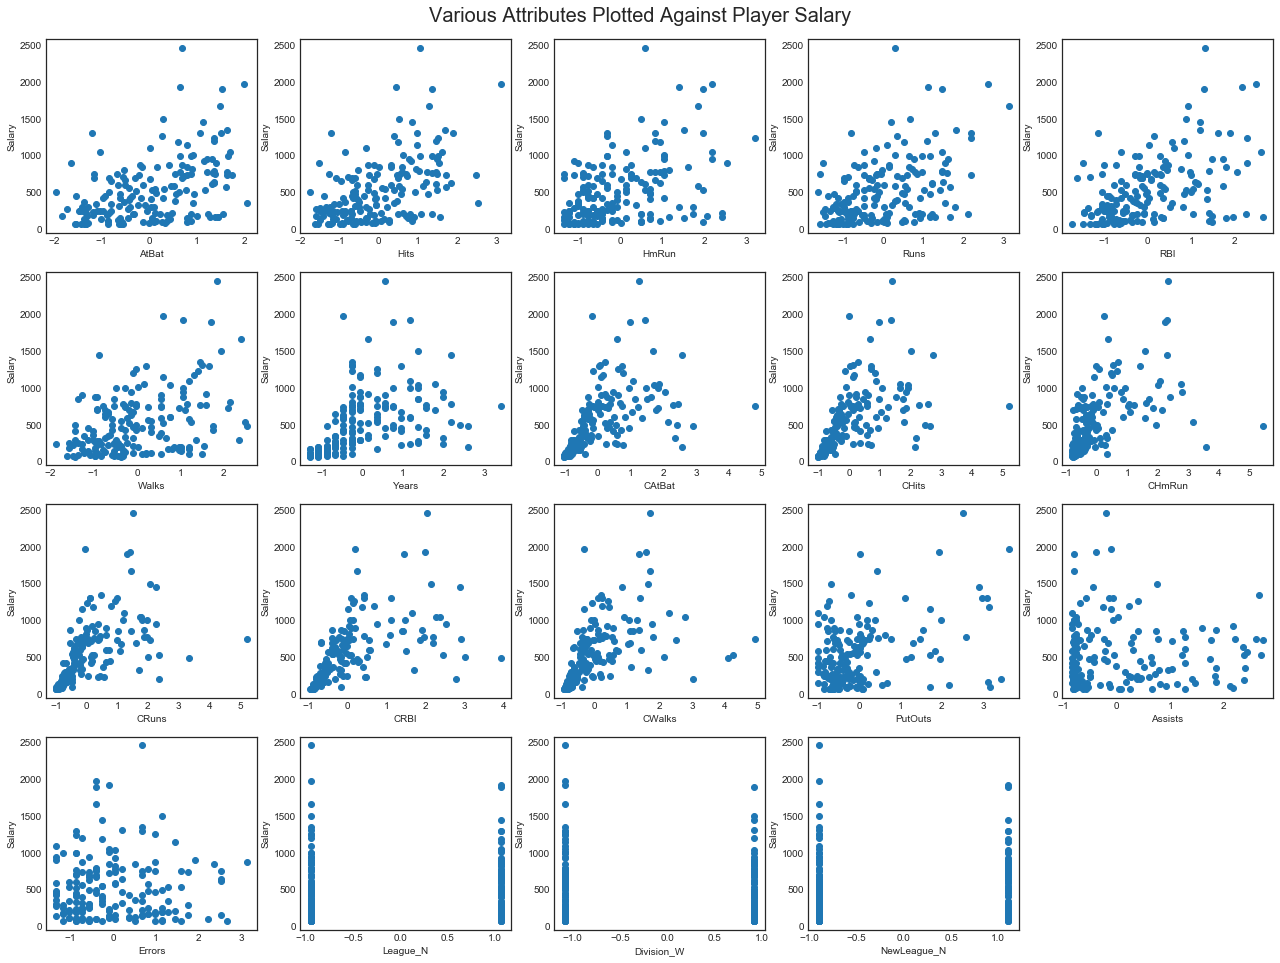

In [10]:
# save the column names
attributes = X_nonTest.columns.values

# compute every correlation score (between each attribute and Salary)
correlations = []
for i, a in enumerate(attributes):
    correlations.append(abs(X_nonTest[a].corr(y_nonTest)))

# display the six highest correlation scores
corr = pd.DataFrame(correlations, index=attributes, columns=["Correlation"])
display(corr.sort_values(by=["Correlation"], ascending=False).head(6))

# create the overall figure
fig = plt.figure(figsize=(22,15))
fig.suptitle("Various Attributes Plotted Against Player Salary", fontsize=20)
fig.subplots_adjust(top=0.95)

# plot every attribute against Salary
ax = []
for i, a in enumerate(attributes):
    ax.append(plt.subplot(4, 5, i + 1))
    ax[i].set_xlabel(a)
    ax[i].set_ylabel("Salary")
    ax[i].scatter(X_nonTest[a], y_nonTest)

#### Make a prediction of the six features that you think will best predict player salary.
We predict that these attributes will best predict Salary:
  - CRuns
  - CRBI
  - CHits
  - CAtBat
  - CHmRun
  - CWalks

This prediction is supported both numerically and visually.

Numerically, this prediction is supported by correlation. We computed correlation between Salary and every other attribute. We then sorted these 19 correlation scores. The list above is simply a list of the first six attributes in the sorted set of correlations.

Visually, we've plotted each of the 19 attributes against Salary. By inspecting these plots, we can see that the six attributes named above seem to have the strongest relationship with Salary. While other relationships do exist (e.g. HmRun and Salary), most of them have too many outliers or too much noise for us to claim a sufficiently-strong (that is, top six) relationship.

# STEP 2:  Write Function For Best-Subset

In [11]:
def bestSubset(X_nonTest, y_nonTest, k):
    kfeatures = [] # placeholder
    kMSE = [] # placeholder
    
    # insert student code here
    
    # identify all k-subsets of our attributes
    subsets = combinations(attributes, k)
    
    # for each k-subset...
    for subset in subsets:
        # 5-fold cross-validation of a linear regression model
        results = cross_validate(
            LinearRegression(),
            X_nonTest[list(subset)],
            y_nonTest,
            cv=5,
            scoring=("neg_mean_squared_error"),
            return_train_score=False
        )
        
        # save the relevant results
        kfeatures.append(list(subset))
        kMSE.append(abs(np.mean(results["test_score"])))
        
    # return the minimum MSE and the related subset of attributes
    return (kfeatures[np.argmin(kMSE)], np.min(kMSE))

# STEP 3:  Execute best subset

In [12]:
# we'll need to save some values
best_subset_features = []
best_subset_mse = []

# let's see how long this takes (just because)
start = timer()

# for each of six model sizes...
for i in range(6):
    print("Starting", i + 1)
    
    # identify the best subset of size i + 1
    f, m = bestSubset(X_nonTest, y_nonTest, i + 1)
    
    # save some values
    best_subset_features.append(f)
    best_subset_mse.append(m)

# output the clock
print("\n", timer() - start, "seconds")

# we don't want simple lists
best_subset_features = np.array(best_subset_features).reshape(-1,1)
best_subset_mse = np.array(best_subset_mse).reshape(-1,1)

# we want our row labels to be more specific than 0, 1, ..., 5
indices = []
for i in range(6):
    indices.append("Best subset: " + str(i + 1))

# we'll use this in step 15
best_stack = np.hstack((best_subset_features, best_subset_mse))

# build a dataframe of the best model for each size
best_subset_models = pd.DataFrame(
    best_stack,
    columns=["Features Included", "MSE"],
    index=indices
)

display(best_subset_models)

Starting 1
Starting 2
Starting 3
Starting 4
Starting 5
Starting 6

 408.90132063100003 seconds


                                                Features Included      MSE
Best subset: 1                                             [CRBI]   128418
Best subset: 2                                       [Hits, CRBI]  97700.2
Best subset: 3                              [Hits, CRBI, PutOuts]  92567.3
Best subset: 4                       [AtBat, Hits, CRBI, PutOuts]  88880.4
Best subset: 5           [AtBat, Hits, CRBI, PutOuts, Division_W]  86494.4
Best subset: 6  [AtBat, Hits, CRBI, PutOuts, League_N, Divisio...  85915.5

#### Discuss any interesting changes in what the model chooses as features – for instance, did a feature which was selected when $k=3$ not get selected when $k>3$?  If so, explain why.

In the context of the question, nothing necessarily "interesting" occurred. However, it is worth mentioning that our step 1 prediction is incorrect. Specifically, we did not expect non-career stats (e.g. Hits) to outperform career stats (e.g. CHits) in predicting Salary. Without being able to adequately plot in more than three dimensions, it's difficult to explore the interactions between various features.

It seems that each feature is relatively unique - the addition of a new feature is not likely to make a previously-optimal set of features suboptimal. Thus, it makes sense that a model of size $j$ includes all features from the model of size $i$ when $j>i$. For this reason, we can expect forward subset selection to select the same features as best subset selection.

# STEP 4:  Plot of Avg Crossval MSE for 6 best models with annotated best point

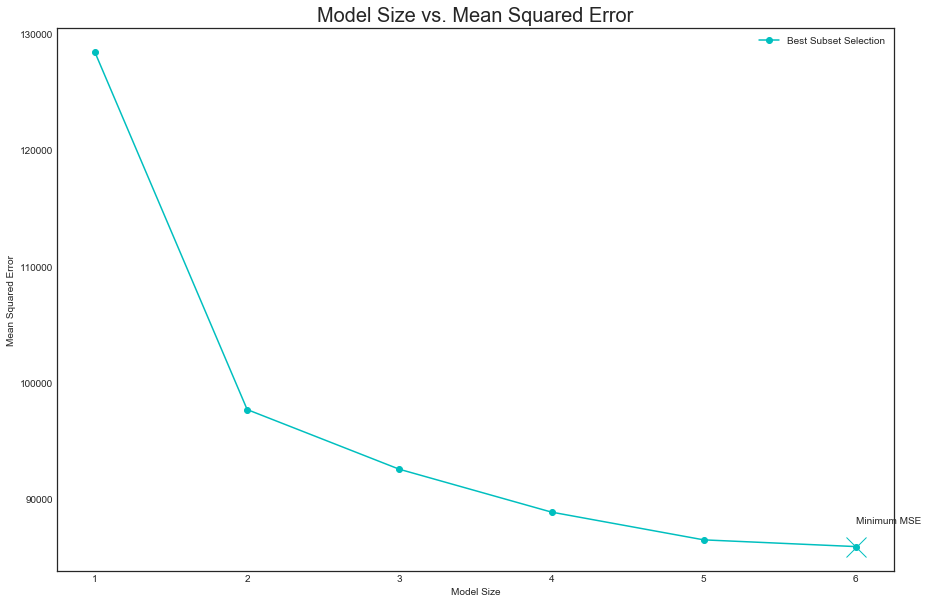

In [13]:
# we need the various model sizes
sizes = np.linspace(1, 6, 6, dtype=int)

# pretty-fy the plot
fig, ax = plt.subplots(1, 1, figsize=(15,10))
ax.set_title("Model Size vs. Mean Squared Error", fontsize=20)
ax.set_xlabel("Model Size")
ax.set_ylabel("Mean Squared Error")
ax.set_xticks(sizes)

# the best subset point with the minimum MSE
min_bs = {
    'x': sizes[np.argmin(best_subset_mse)],
    'y': np.min(best_subset_mse),
    'c': 'c'
}

# add a label for the point with the minimum MSE
ax.annotate("Minimum MSE", xy=(min_bs['x'], min_bs['y']), xytext=(min_bs['x'], min_bs['y'] + 2000))

# also, put a big fat "x" on that point
ax.plot([min_bs['x']], [min_bs['y']], color=min_bs['c'], marker='x', markersize=20)

# plot the stuff
ax.plot(sizes, best_subset_mse, label="Best Subset Selection", color=min_bs['c'], marker='o')
ax.legend()

# STEP 5:  Discussion of best subset models

#### Report $k$ and the validation set MSE on the model with the best $k$ features.

The best model with six features outperforms all other models with six or fewer features. According to the table displayed in step 3, it has a mean squared error of 85915.5. The six features that give this model the best performance are AtBat, Hits, CRBI, PutOuts, League_N, and Division_W.

#### Describe the change in these values as the model size grows from 1 to 6.

As the model size increases, the mean squared error decreases. However, the difference in MSE shrinks as we increase model size. In other words, the MSE for model size two is much lower than for model size one, but it's only a bit higher than for model size three (and so on from left to right). It appears that the curve is approaching an asymptote, so we can predict that larger models are not likely to significantly improve validation performance.

#### Discuss your findings from the algorithmic best subset selection method and compare the evidence to the features you eyeballed as valuable in step 1.

According to best subset selection, CRBI is the single best predictor for Salary. However, the results above seem to indicate that the other career stats (e.g. CHmRun, CAtBat) don't give significant performance improvement - at least when compared to AtBat, Hits, PutOuts, League_N, and Division_W.

This is not what we predicted in step 1. One possible explanation for this is that the various career stats interact in such a way that training on more than one does not adequately predict Salary. It's possible that the stats are well-correlated with each other, and this might indicate that they are not unique enough to significantly improve the Salary prediction in combination.

# STEP 6:  Write Function For Forward Stepwise Subset Selection

In [14]:
def forwardStepwiseSubset(X_nonTest,y_nonTest, k):
    # insert student code here
    
    # an updated list of so-far-unpicked attributes
    remaining = attributes.copy()
    
    # an updated list of so-far-picked attributes
    current = []
    
    # save this for later
    mse = 0

    # for each step size...
    for i in range(k):
        kfeatures = []
        kMSE = []
        
        # for every available attribute...
        for attr in remaining:
            # add attr to our currently-selected subset
            temp = current.copy()
            temp.append(attr)
            
            # 5-fold cross-validation of a linear regression model
            results = cross_validate(
                LinearRegression(),
                X_nonTest[temp],
                y_nonTest,
                cv=5,
                scoring=("neg_mean_squared_error"),
                return_train_score=False
            )

            # save the relevant results
            kfeatures.append(attr)
            kMSE.append(abs(np.mean(results["test_score"])))
            
        # move new attribute from remaining to current; update MSE 
        current.append(kfeatures[np.argmin(kMSE)])
        remaining = np.delete(remaining, np.argwhere(remaining == kfeatures[np.argmin(kMSE)]))
        mse = np.min(kMSE)
        
    # return the minimum MSE and the related subset of attributes
    return current, mse

# STEP 7:  Execute Forward subset

In [15]:
# we'll need to save some values
forward_subset_features = []
forward_subset_mse = []

# for each of six model sizes...
for i in range(6):
    # identify the best subset for a specific model size
    f, m = forwardStepwiseSubset(X_nonTest, y_nonTest, i + 1)
    
    # save the values
    forward_subset_features.append(f)
    forward_subset_mse.append(m)

# we don't want simple lists
forward_subset_features = np.array(forward_subset_features).reshape(-1,1)
forward_subset_mse = np.array(forward_subset_mse).reshape(-1,1)

# we want our row labels to be more specific than 0, 1, ..., 5
indices = []
for i in range(6):
    indices.append("Forward subset: " + str(i + 1))

# we'll use this in step 15
forward_stack = np.hstack((forward_subset_features, forward_subset_mse))

# build a dataframe of the best model for each size
forward_subset_models = pd.DataFrame(
    forward_stack,
    columns=["Features Included", "MSE"],
    index=indices
)

display(forward_subset_models)

                                                   Features Included      MSE
Forward subset: 1                                             [CRBI]   128418
Forward subset: 2                                       [CRBI, Hits]  97700.2
Forward subset: 3                              [CRBI, Hits, PutOuts]  92567.3
Forward subset: 4                       [CRBI, Hits, PutOuts, AtBat]  88880.4
Forward subset: 5           [CRBI, Hits, PutOuts, AtBat, Division_W]  86494.4
Forward subset: 6  [CRBI, Hits, PutOuts, AtBat, Division_W, Leagu...  85915.5

#### Discuss how the stepwise-selected features changed compared to how the best-subset-selected features changed (in step 5).

As expected, forward subset selection selected the same features as did best subset selection. The MSE values, of course, are identical - once the features are selected, the linear regression and cross-validation procedures do not change.

# STEP 8:  Updated Plot of Avg Crossval MSE & best points

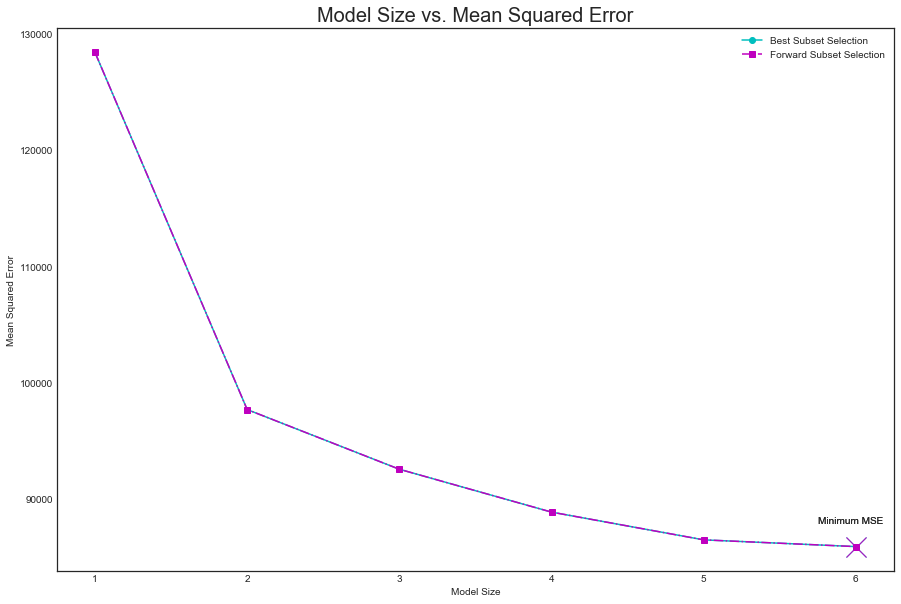

In [16]:
# pretty-fy the plot
fig, ax = plt.subplots(1, 1, figsize=(15,10))
ax.set_title("Model Size vs. Mean Squared Error", fontsize=20)
ax.set_xlabel("Model Size")
ax.set_ylabel("Mean Squared Error")
ax.set_xticks(sizes)

# the forward subset point with the minimum MSE
min_fs = {
    'x': sizes[np.argmin(forward_subset_mse)],
    'y': np.min(forward_subset_mse),
    'c': 'm'
}

# add a label for the points with the minimum MSE
# also, put a big fat "x" on both of those points
for m in (min_bs, min_fs):
    ax.annotate("Minimum MSE", xy=(m['x'], m['y']), xytext=(m['x'] - 0.25, m['y'] + 2000))
    ax.plot([m['x']], [m['y']], color=m['c'], marker='x', markersize=20)

# plot the stuff
ax.plot(sizes, best_subset_mse, label="Best Subset Selection", linestyle='-', color=min_bs['c'], marker='o')
ax.plot(sizes, forward_subset_mse, label="Forward Subset Selection", linestyle='-.', color=min_fs['c'], marker='s')
ax.legend()

# STEP 9:  Discussion of best foward-stepwise models 

#### Describe the change in these values as the model size grows from 1 to 6.

These values change exactly as they do for best subset. Specifically, MSE decreases asymptotically as we increase the model size (with a sharp decrease between the best model of size one and the best model of size two). Because it seems we're close to the asymptote for the size six model, we can expect a model of size seven (or larger) to perform pretty much the same (or worse, as we begin to overfit) as for size six.

#### Report the MSE and the features in the set for this best stepwise model.

As shown in the plot, the best model size (between one and six) for forward stepwise selection is size $k=6$. We can see from the table in step 7 that this model uses the features CRBI, Hits, PutOuts, AtBat, Division_W, and League_N and has an MSE value of 85915.5.

#### Discuss your findings from the forward subset selection method and compare the evidence to the features you eyeballed as valuable in step 1.

Forward-stepwise subset selection actually selected the exact same features as best subset selection for every model size (or at least for sizes one through six). Again, this is not what we predicted in step 1. The prediction assumes that the career stats (e.g. CRBI, CAtBat, CRuns) build on each other to give better models - forward-stepwise subset selection (and best subset selection) show that this is not the case. Specifically, we see CRBI is a relatively-useful single-feature predictor, but that, for larger model sizes, non-career features (e.g. Hits, Division_W) work with CRBI to build a better model than do the career features.

# STEP 10: Discussion and comparison of subset selection methods

#### Discuss the outcomes in terms of the tradespace (accuracy, computational complexity) between the greedy feature selection approach and the optimal feature selection approach.

For this problem, the greedy approach is significantly better. It gives the *exact same solution* in a fraction of the time. For this reason, we feel there is no justification for the optimal feature selection approach in this dataset.

For other problems, it's not unusual for the greedy approach to miss the optimal solution - perhaps due to some strong relation between "weak" features (that is, a low-value feature that the greedy approach will never select in an early step, so we won't ever see the strong relation in a later step). Thus, we should always consider the problem domain when selecting the best approach. If the search space is reasonably-sized, we could also follow both approaches (as we did here) to identify which is best.

#### Are the best feature sets from each algorithm (“best-subset” & “forward-stepwise”) models the same? Different? Compare their validation set classification accuracy performances.

The best feature sets are exactly the same. Because we are using linear regression to fit the features given by both algorithms, the validation set accuracy values are also identical.

#### Explain these results in terms of independence or interdependence of the features on classification.

As alluded to previously, then, we claim that these features are mostly independent of each other. If we have an optimal feature set $X$ for a given size, a suboptimal feature set $X'$ for the same size, and some other feature $y\notin X, y\notin X'$, we're not going to see a case where a model fit to $X'\cup \{y\}$ outperforms a model fit to $X\cup \{y\}$. In other words, the independence of the features means that, if some feature is optimal at some size, it's also optimal at all larger sizes - feature inter-relationships won't change this.

# STEP 11: Write a function to execute LASSO

In [17]:
def LASSOSubset(X_nonTest, y_nonTest, k):
    # logarithmically spaced alphas for LASSO
    alphas = np.logspace(-1, 2.5, num=1000)
    
    # insert student code here
    
    # we'll need this later
    model = None
    
    # fit lasso over successive alphas until we have exactly k nonzero coefficients
    for alpha in alphas:
        model = Lasso(alpha=alpha, random_state=7)
        model.fit(X_nonTest, y_nonTest)
        
        # stop looping when we find the first alpha that fits our purposes
        if np.count_nonzero(model.coef_) == k:
            break

    # 5-fold cross-validation of a linear regression model using only the attributes selected by lasso
    results = cross_validate(
        model,
        X_nonTest,
        y_nonTest,
        cv=5,
        scoring=("neg_mean_squared_error"),
        return_train_score=False
    )
    
    return (
        list(attributes[np.nonzero(model.coef_)]),
        abs(np.mean(results["test_score"])),
        alphas[i]
    )

# STEP 12: Execute LASSO

In [18]:
# we'll need to save some values
lasso_subset_features = []
lasso_subset_mse = []
lasso_subset_alpha = []

# for each of six model sizes...
for i in range(6):
    # identify the best subset for a specific model size
    f, m, a = LASSOSubset(X_nonTest, y_nonTest, i + 1)
    
    # save the values
    lasso_subset_features.append(f)
    lasso_subset_mse.append(m)
    lasso_subset_alpha.append(a)

# we don't want simple lists
lasso_subset_features = np.array(lasso_subset_features).reshape(-1,1)
lasso_subset_mse = np.array(lasso_subset_mse).reshape(-1,1)
lasso_subset_alpha = np.array(lasso_subset_alpha).reshape(-1,1)

# we want our row labels to be more specific than 0, 1, ..., 5
indices = []
for i in range(6):
    indices.append("Lasso subset: " + str(i + 1))

# we'll use this in step 15
lasso_stack = np.hstack((lasso_subset_features, lasso_subset_mse, lasso_subset_alpha))

# build a dataframe of the best model for each size
lasso_subset_models = pd.DataFrame(
    lasso_stack,
    columns=["Features Included", "MSE", "Alpha"],
    index=indices
)

display(lasso_subset_models)

                                                Features Included     MSE  \
Lasso subset: 1                                           [CRuns]  185366   
Lasso subset: 2                                     [CRuns, CRBI]  165904   
Lasso subset: 3                               [Hits, CRuns, CRBI]  122414   
Lasso subset: 4                      [Hits, CRuns, CRBI, PutOuts]  105069   
Lasso subset: 5              [Hits, CHmRun, CRuns, CRBI, PutOuts]  103915   
Lasso subset: 6  [Hits, CHmRun, CRuns, CRBI, PutOuts, Division_W]  103763   

                    Alpha  
Lasso subset: 1       0.1  
Lasso subset: 2   0.10081  
Lasso subset: 3  0.101627  
Lasso subset: 4   0.10245  
Lasso subset: 5  0.103279  
Lasso subset: 6  0.104116  

# STEP 13: Updated Plot of Avg Crossval MSE & best points

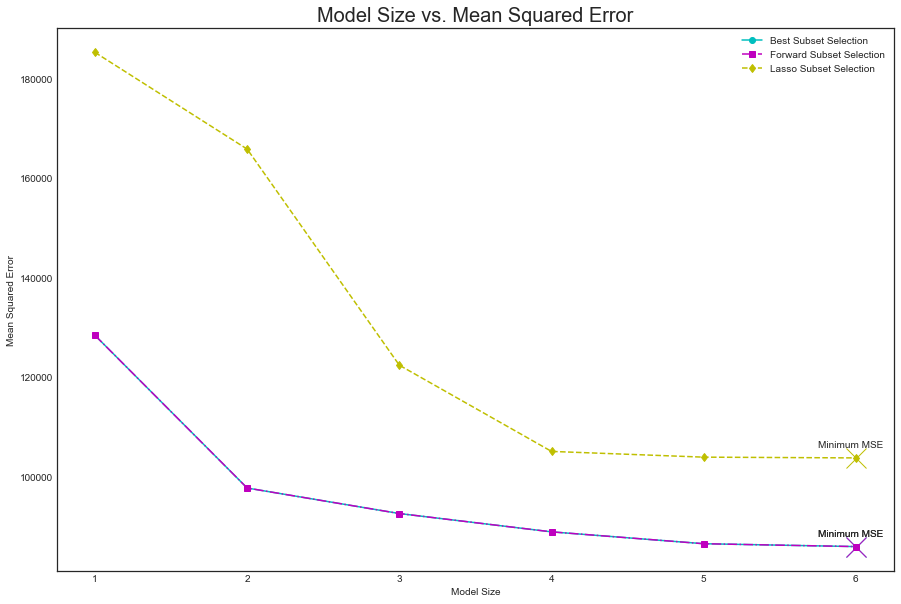

In [19]:
# pretty-fy the plot
fig, ax = plt.subplots(1, 1, figsize=(15,10))
ax.set_title("Model Size vs. Mean Squared Error", fontsize=20)
ax.set_xlabel("Model Size")
ax.set_ylabel("Mean Squared Error")
ax.set_xticks(sizes)

# the lasso subset point with the minimum MSE
min_ls = {
    'x': sizes[np.argmin(lasso_subset_mse)],
    'y': np.min(lasso_subset_mse),
    'c': 'y'
}

# add a label for the points with the minimum MSE
# also, put a big fat "x" on each of those points
for m in (min_bs, min_fs, min_ls):
    ax.annotate("Minimum MSE", xy=(m['x'], m['y']), xytext=(m['x'] - 0.25, m['y'] + 2000))
    ax.plot([m['x']], [m['y']], color=m['c'], marker='x', markersize=20)

# plot the stuff
ax.plot(sizes, best_subset_mse, label="Best Subset Selection", linestyle='-', color=min_bs['c'], marker='o')
ax.plot(sizes, forward_subset_mse, label="Forward Subset Selection", linestyle='-.', color=min_fs['c'], marker='s')
ax.plot(sizes, lasso_subset_mse, label="Lasso Subset Selection", linestyle='--', color=min_ls['c'], marker='d')
ax.legend()

# STEP 14: Discussion of best LASSO models 

#### Describe the change in these values as the model size grows from 1 to 6.

The MSE values decrease as we move from a model of size one to a model of size six. At size four, though, we effectively bottom out, and the size five and six models perform only a tiny bit better than the size four model. We predict that models of size seven and up will perform much like these three.

#### Report the MSE and the features in the set for this best LASSO model.

As shown in the plot, the best model size (between one and six) for forward stepwise selection is size $𝑘=6$. We can see from the table in step 12 that this model uses the features Hits, CHmRun, CRuns, CRBI, PutOuts, and Division_W and has an MSE value of 103763. Note that the size four and five models have similar MSE values.

#### Discuss your findings from the LASSO method and compare the evidence to the features you eyeballed as valuable in step 1.

We see in the plot above that the LASSO method does not perform as well as the best/forward-stepwise subset selection methods. It also selects different features. For example, the best and forward-stepwise methods select CRBI, Hits, PutOuts, AtBat, Division_W, and League_N, but the LASSO method selects Hits, CHmRun, CRuns, CRBI, PutOuts, and Division_W.

In step 1, we predicted that the six career stats would be the top six predictors of salary. The six LASSO-selected features are more closely-aligned with our step 1 prediction than are the features selected by best/forward-stepwise subset selection. Specifically, the LASSO-selected features include three career stats (CHmRun, CRuns, and CRBI); the other two methods only include CRBI.

# STEP 15: Answer Customer Questions

Remember to provide clear evidence and rationale for your decisions.

#### a. For estimating the value of the of the output variable (Y) on the dataset, what are the recommended input features (and regularization settings) to use for model sizes with feature counts between 1 and 6?

In the table below, we can see the best MSE (and associated features) for all 18 models.

In [20]:
# save the row labels
indices = np.concatenate((best_subset_models.index, forward_subset_models.index, lasso_subset_models.index))

# build a dataframe with all results feature/MSE/alpha results
results = pd.DataFrame(
    np.vstack((
        np.hstack((best_stack, np.full((len(best_stack), 1), "-"))),
        np.hstack((forward_stack, np.full((len(forward_stack), 1), "-"))),
        lasso_stack
    )),
    columns=lasso_subset_models.columns.values,
    index=indices
)

display(results)

                                                   Features Included      MSE  \
Best subset: 1                                                [CRBI]   128418   
Best subset: 2                                          [Hits, CRBI]  97700.2   
Best subset: 3                                 [Hits, CRBI, PutOuts]  92567.3   
Best subset: 4                          [AtBat, Hits, CRBI, PutOuts]  88880.4   
Best subset: 5              [AtBat, Hits, CRBI, PutOuts, Division_W]  86494.4   
Best subset: 6     [AtBat, Hits, CRBI, PutOuts, League_N, Divisio...  85915.5   
Forward subset: 1                                             [CRBI]   128418   
Forward subset: 2                                       [CRBI, Hits]  97700.2   
Forward subset: 3                              [CRBI, Hits, PutOuts]  92567.3   
Forward subset: 4                       [CRBI, Hits, PutOuts, AtBat]  88880.4   
Forward subset: 5           [CRBI, Hits, PutOuts, AtBat, Division_W]  86494.4   
Forward subset: 6  [CRBI, Hi

#### b. For this data, over all of the techniques explored, which size model (and feature set) yields the best model performance?

According to the table above (and the plot in step 13), for every model size between one and six, the LASSO-selected subset performs worse (that is, gives a higher MSE) than does the best/forward-stepwise subset. For this reason, we can confidently claim that the best and forward-stepwise subset selection methods are better for this dataset than is the LASSO method.

Because best subset selection gives the exact same subsets and MSE values as does forward-stepwise subset selection, and because the greedy approach runs much, much faster than does the optimal approach, we further claim that one should use the greedy approach to select feature sets from this dataset.

In either case, the two non-LASSO methods perform better than the LASSO method, and both indicate that the model of size six gives the best performance. Because they give the exact same feature sets for every model size, we should thus use the following six features to best predict Y for model sizes between one and six:
- CRBI
- Hits
- PutOuts
- AtBat
- Division_W
- League_N

For completeness, we show below the test set performance for our "best" model.

In [21]:
test_features, test_mse = forwardStepwiseSubset(X_test, y_test, 6)

print("Selected features  :", test_features)
print("Mean squared error :", test_mse)

Selected features  : ['CHmRun', 'Walks', 'Division_W', 'Years', 'CHits', 'PutOuts']
Mean squared error : 147135.05372539948


#### A discussion of the Salary values
In step 0, we scaled all predictors. We did not scale (transform) the true response values. In doing so, we see that our various models give extremely high MSE values (85,000+).

In a real-world scenario, we would likely plot the Salary values so as to better explore our data. We would then see that the Salary values are not distributed uniformly. In fact, they are heavily skewed towards the minimum value. To better fit a model, then, we would (logarithmically, in this case) transform the Salary data before proceeding.

For this dataset, doing so certainly gives better MSE values (between ~1.0 and ~4.0), but we would of course need to undo our transformation before reporting a player's predicted Salary.

Still, the procedure followed in the previous steps is sufficient for this dataset.

END OF ASSIGNMENT